In [1]:
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Dynamic information - Update before running
# -------------------------------------------------------

# Pre-Retirement Calculation
starting_balance = 20000
pre_tax_annual_income = 125000
percentage_contribution = 0.22
contribution_growth_rate = 0.03
annual_raise = 0.04
market_growth_rate = 0.08
current_age = 22
retirement_age = 50

# Tax Information
tax_brackets = [11925, 48475, 103350, 197300, 250525, 626350]
tax_rates = [0.10, 0.12, 0.22, 0.24, 0.32, 0.35, 0.37]

In [2]:
# Static information
balance_all = [starting_balance] * 26 * (retirement_age - current_age)
balance_income = [starting_balance] * 26 * (retirement_age - current_age)
contribution_amount = [pre_tax_annual_income * percentage_contribution / 26] * 26 * (retirement_age - current_age)
starting_capital = [starting_balance] * 26 * (retirement_age - current_age)
age_interest_exceed_income = -1

def calculate_post_tax_income(income):
    return helper_post_tax_income(income, 0)
    
def helper_post_tax_income(income, i):
    if(i > 5 or income < tax_brackets[i]):
        return (1 - tax_rates[i]) * income
    return (1 - tax_rates[i]) * tax_brackets[i] + helper_post_tax_income(income - tax_brackets[i], i + 1)

# Calculate post-tax income
for i in range(len(tax_brackets) - 1, 0, -1):
    tax_brackets[i] -= tax_brackets[i-1]
post_tax_annual_income = calculate_post_tax_income(pre_tax_annual_income)

# Print post-tax income
print("Post-Tax Annual Income: \033[1m" + str(post_tax_annual_income) + "\033[0m")

Post-Tax Annual Income: 102153.0


In [3]:
# Run market simulation
tail_index = (retirement_age - current_age) * 26
for i in range(1, tail_index):
    post_tax_income = calculate_post_tax_income(pre_tax_annual_income * (1 + annual_raise) ** int(i / 26))
    contribution = post_tax_income * percentage_contribution / 26 * (1 + contribution_growth_rate) ** int(i / 26)
    balance_all[i] = balance_all[i-1] * (1 + market_growth_rate / 365) ** 14 + contribution
    balance_income[i] = balance_income[i-1] + contribution
    contribution_amount[i] = contribution
    if(age_interest_exceed_income == -1 and balance_all[i] - balance_all[i-1] - contribution > post_tax_income / 26):
        age_interest_exceed_income = int(i/26) + current_age

# Calculate maximum retirement withdrawal
retirement_withdrawal_max = balance_all[tail_index - 1] * (1 + market_growth_rate / 365) ** 30 - balance_all[tail_index - 1]

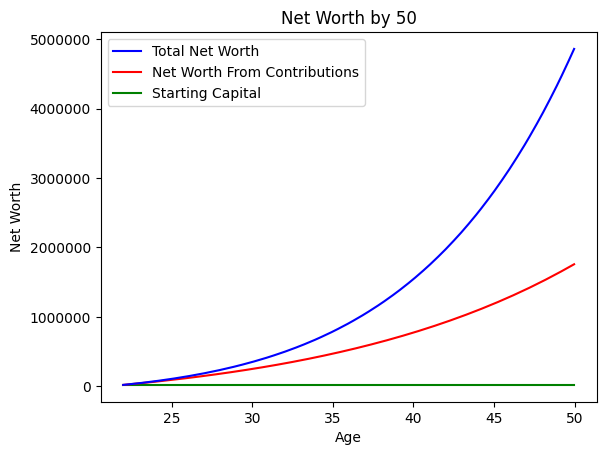

Maximum monthly withdrawal after retirement to maintin net worth: 32056.89

Age that investment interest exceeds income: 45


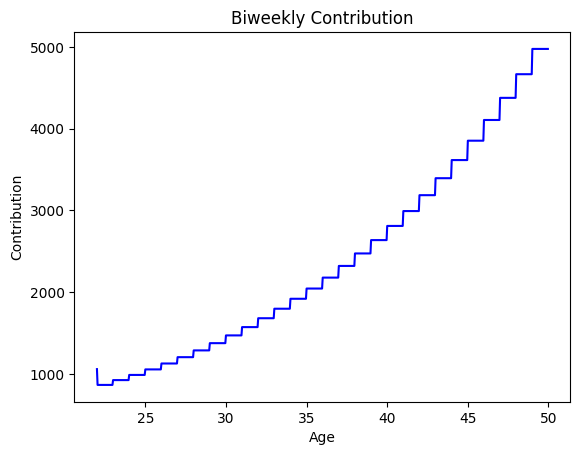

In [4]:
# Reformat from biweekly to yearly timespan
years_range = list(map(lambda x: x / 26, range(current_age * 26, current_age * 26 + len(balance_all))))

# Plot net worth
plt.plot(years_range, balance_all, 'b', label='Total Net Worth', zorder=2)
plt.plot(years_range, balance_income, 'r', label='Net Worth From Contributions', zorder=1)
plt.plot(years_range, starting_capital, 'g', label='Starting Capital', zorder=0)
plt.ticklabel_format(axis='y', style='plain')
plt.title("Net Worth by " + str(retirement_age))
plt.xlabel('Age')
plt.ylabel('Net Worth')
plt.legend(loc='upper left')
plt.show()

# Print maximum retirement withdrawal
print("Maximum monthly withdrawal after retirement to maintin net worth: \033[1m" + str(round(retirement_withdrawal_max, 2)) + "\033[0m\n")

# Print age interest exceeds income
print("Age that investment interest exceeds income: \033[1m" + str(age_interest_exceed_income) + "\033[0m")

# Plot biweekly contribution
plt.plot(years_range, contribution_amount, 'b')
plt.ticklabel_format(axis='y', style='plain')
plt.title("Biweekly Contribution")
plt.xlabel('Age')
plt.ylabel('Contribution')
plt.show()